# **Section:** FP

In [131]:
import os
import itertools as it
import warnings
import time
import pickle

import numpy as np

import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns

import joblib

import pathlib

import feets.preprocess

from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import DataConversionWarning
from sklearn.model_selection import (
    KFold, StratifiedKFold, train_test_split)

from sklearn import metrics

from PyAstronomy.pyasl import foldAt

import tqdm

from libs.container import Container
from libs.nearest import nearest
from libs.experiment import WithAnotherExperiment, roc, metrics
from libs.precstar import  prec_star

warnings.simplefilter("ignore", category=DataConversionWarning)

In [2]:
%%time

PATH = pathlib.Path(os.path.abspath(os.path.dirname("")))

DATA_PATH = PATH / "_data"

COLUMNS_NO_FEATURES = ['id', 'tile', 'cnt', 'ra_k', 'dec_k', 'vs_type', 'vs_catalog', 'cls'] 

path = "_data/full_scaled.pkl.bz2"

train_datas = {}

sample = pd.readfeets.preprocessth)

# the features
X_columns = [c for c in sample.columns if c not in COLUMNS_NO_FEATURES]
y_column = "cls"

sample[X_columns] =  sample[X_columns].astype(np.float32)

data = Container({k: v for k, v in sample.groupby("tile")})

del sample

CPU times: user 20min 51s, sys: 3min 43s, total: 24min 34s
Wall time: 6min 6s


In [50]:
%%time

COLUMNS_NO_FEATURES = ['id', 'tile', 'cnt', 'ra_k', 'dec_k', 'vs_type', 'vs_catalog', 'cls'] 

path = "_data/full.pkl.bz2"

sample = pd.read_pickle(path)

data_original = Container({k: v for k, v in sample.groupby("tile")})

del sample

CPU times: user 3min 56s, sys: 8.68 s, total: 4min 5s
Wall time: 3min 56s


In [113]:
CACHE_FOLDER = pathlib.Path("_cache") / "FP"

def cache_or_run(*, fname, run, force=False):
    path = CACHE_FOLDER / fname
    if not isinstance(path, pathlib.Path):
        path = pathlib.Path(path)
    
    if path.exists() and not force:
        print("cache")
        return joblib.load(path)
    
    value = run()
    joblib.dump(value, path, compress=3)
    return value

In [111]:
CACHE_FOLDER = pathlib.Path("_cache") / "ALL_kfolds"
thresholds = joblib.load(CACHE_FOLDER / "thresholds.pkl.bz2")
thresholds

{'b206': 0.49,
 'b214': 0.33599999999999997,
 'b216': 0.394,
 'b220': 0.536,
 'b228': 0.28600000000000003,
 'b234': 0.42600000000000005,
 'b247': 0.6799999999999999,
 'b248': 0.652,
 'b261': 0.654,
 'b262': 0.5800000000000001,
 'b263': 0.5700000000000001,
 'b264': 0.628,
 'b277': 0.43600000000000005,
 'b278': 0.49,
 'b360': 0.19399999999999995,
 'b396': 0.010000000000000009}

In [6]:
ensemble = joblib.load(CACHE_FOLDER / "ensemble.pkl.bz2")

In [82]:
def clf_table(tile, results):
    
    fix_recall, fix_precs = {}, {}
    for r in results:
        train_name, test_name = r["train_name"], r["test_name"]
        if test_name == tile:
            break
    
    efold_thrs = np.average([v for k, v in thresholds.items() if k != train_name])
    probs = r["probabilities"][:,1]
    predicted = (probs >= efold_thrs).astype(int)
    
    df = data_original[tile].copy()
    
    
    df["id2"] = data[tile].id.values
    df["predicted"] = predicted
    df["FP"] = ((r.real_cls == 0) & (predicted == 1))
    df["threshold"] = [efold_thrs] * len(data[tile])
    df["probs"] = probs
    
    if (df.id - df.id2).sum():
        raise Exception("Bad merged")
    
    df = df.drop("id2", axis=1)

    return df 


def get_fps():
    fps = Container()
    for tile in data.keys():
        df = clf_table(tile, ensemble)
        df = df[df.FP]
        fps[tile] = df
    return fps

fps = get_fps()

In [117]:
%%time

def get_lcs(fps):
    lcs = []
    for tile, fp in fps.items():
        if len(fp) == 0:
            continue
        fpath = f"/home/jbcabral/carpyncho3/production_data/stored/light_curves/{tile}/lc_obs_{tile}.npy"
        lc = pd.DataFrame(np.load(fpath))
        lc = lc[lc.bm_src_id.isin(fp.id.values)]
        lcs.append(lc)
    return pd.concat(lcs, ignore_index=True, sort=False)


lcs = cache_or_run(
    fname="lcs.pkl.bz2",
    run=lambda: get_lcs(fps)    
)

cache
CPU times: user 158 ms, sys: 2.69 ms, total: 161 ms
Wall time: 162 ms


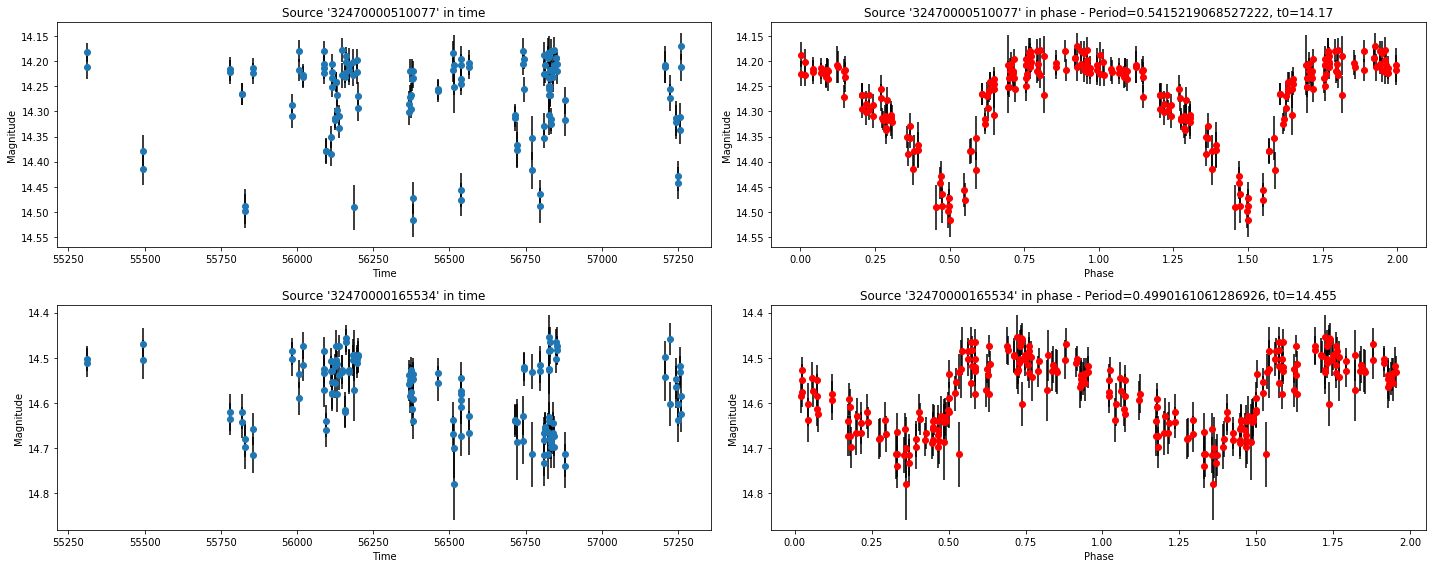

In [158]:
def get_ts(lcs, id):
    ts = lcs[lcs.bm_src_id == id]
    
    time, mag, err = (
        ts.pwp_stack_src_hjd.values, 
        ts.pwp_stack_src_mag3.values, 
        ts.pwp_stack_src_mag_err3.values)
    
    sort = np.argsort(time)
    
    time, mag, err = time[sort], mag[sort], err[sort]
    time, mag, err = feets.preprocess.remove_noise(time, mag, err, std_limit=3)
    return time, mag, err


def plot_lc(*, tax, pax, sid, lcs, fps):
    time, mag, err = get_ts(lcs, sid)
    
    tax.errorbar(time, mag, err, ls="", marker="o", ecolor="k")
    tax.set_xlabel("Time")
    tax.set_ylabel("Magnitude")
    tax.invert_yaxis()
    
    t0 = np.min(mag)
    period = fps[fps.id == sid].PeriodLS.values[0]
    
    phases = foldAt(time, period, T0=t0)
    sort = np.argsort(phases)
    
    phases, pmag, perr = phases[sort], mag[sort], err[sort]
    phases = np.hstack((phases, phases + 1))
    pmag = np.hstack((pmag, pmag))
    perr = np.hstack((perr, perr))
    
    
    pax.errorbar(phases, pmag, perr, ls="", marker="o", ecolor="k", color="r")
    pax.set_title(f"Source '{sid}' in phase - Period={period}, t0={t0}")
    pax.set_xlabel("Phase")
    pax.set_ylabel("Magnitude")
    pax.invert_yaxis()


def plot_tile_lc(tile, fps, lcs):
    df = fps[tile]
    ids = df.sort_values("probs", ascending=False).id.values
    
    size = len(ids)
    fig, all_axs = plt.subplots(size, 2, figsize=(20, 4 * size))
    
    for sid, axs in zip(ids, all_axs):
        plot_lc(tax=axs[0], pax=axs[1], sid=sid, lcs=lcs, fps=df)
        axs[0]
    
    return fig, axs

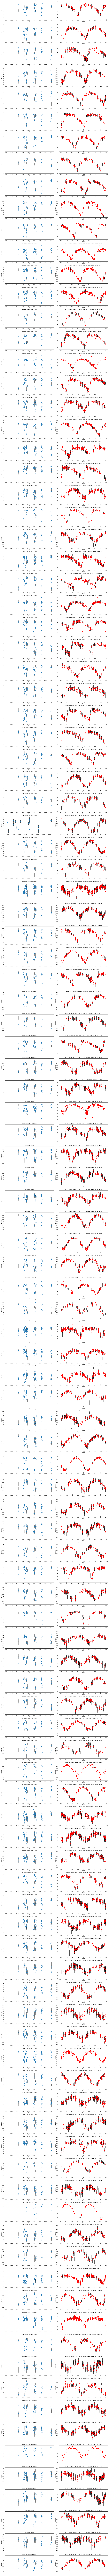

In [162]:
fig, axs = plot_tile_lc(tile="b396", fps=fps, lcs=lcs)
fig.tight_layout()

In [159]:
fps

<Container({'b206': 3, 'b214': 17, 'b216': 21, 'b220': 15, 'b228': 18, 'b234': 23, 'b247': 2, 'b248': 1, 'b261': 0, 'b262': 0, 'b263': 1, 'b264': 0, 'b277': 0, 'b278': 0, 'b360': 24, 'b396': 117})>